# Explore Exercises

In [14]:
#imports
import re
import unicodedata
import pandas as pd
import nltk

import env as e

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



### 1. Spam Data


* Load the spam data set.


In [2]:
url = e.get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [6]:
df['clean_text'] = df['text'].apply(clean)

In [7]:
df.head()

,label,text,clean_text
id,,,
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[dun, say, early, hor, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"


* Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?


In [8]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels


,n,percent
label,,
ham,4825,0.865937
spam,747,0.134063


In [9]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


In [10]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()


call    359
free    216
txt     150
ur      144
text    137
Name: count, dtype: int64

In [11]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [12]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [13]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])


,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


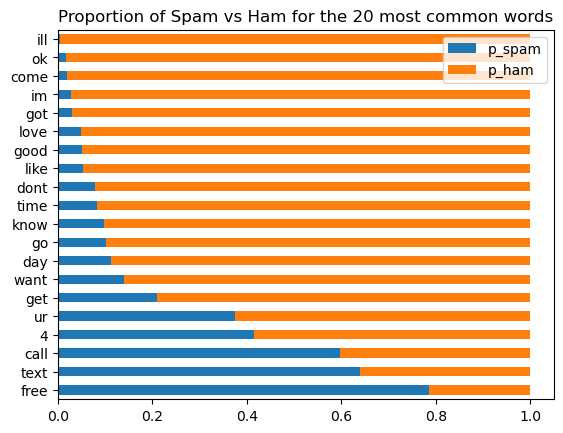

In [16]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')
plt.show()


In [18]:
from wordcloud import WordCloud

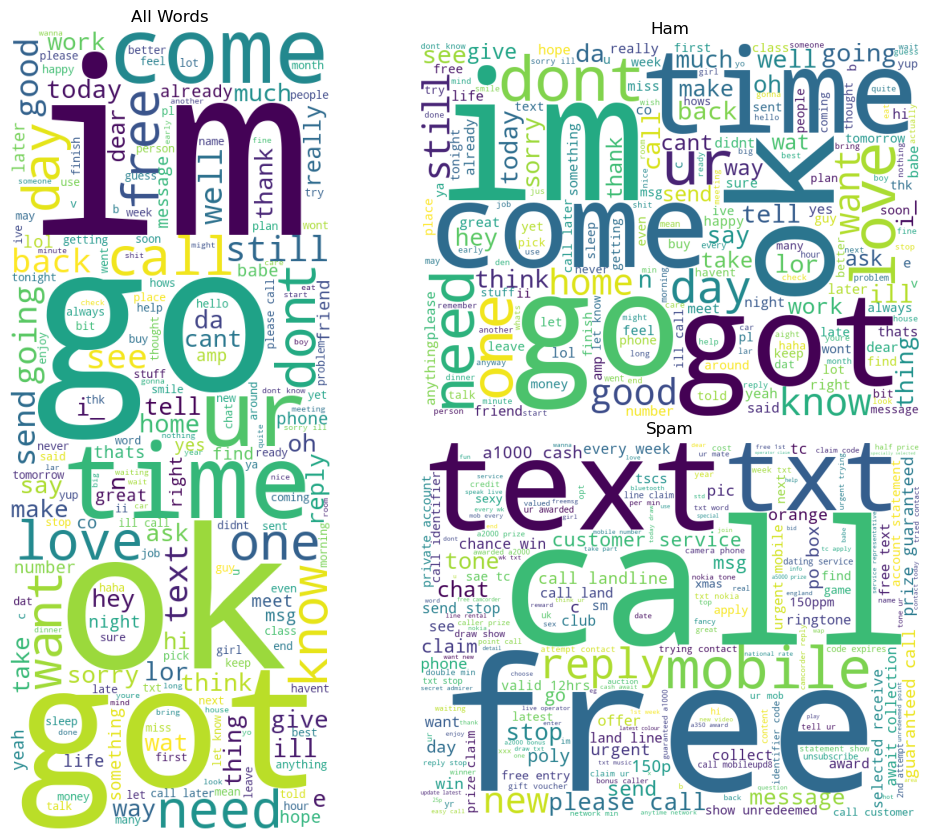

In [19]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


* Is there any overlap in the bigrams for the spam data and the ham data?


In [20]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()


(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
Name: count, dtype: int64

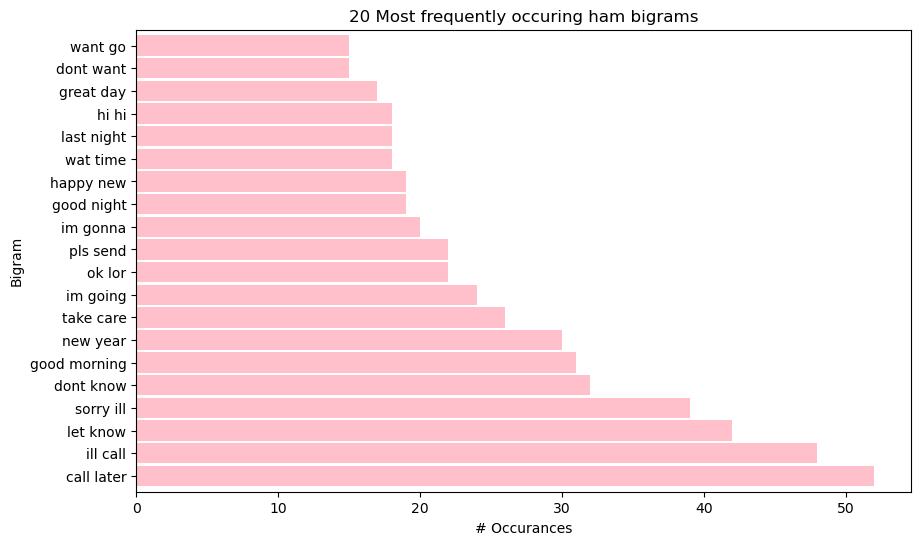

In [21]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


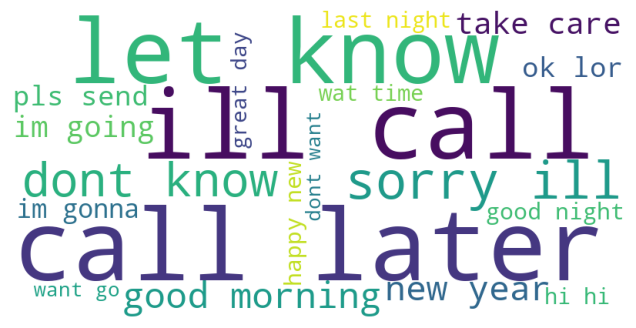

In [22]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


In [23]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()


(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
Name: count, dtype: int64

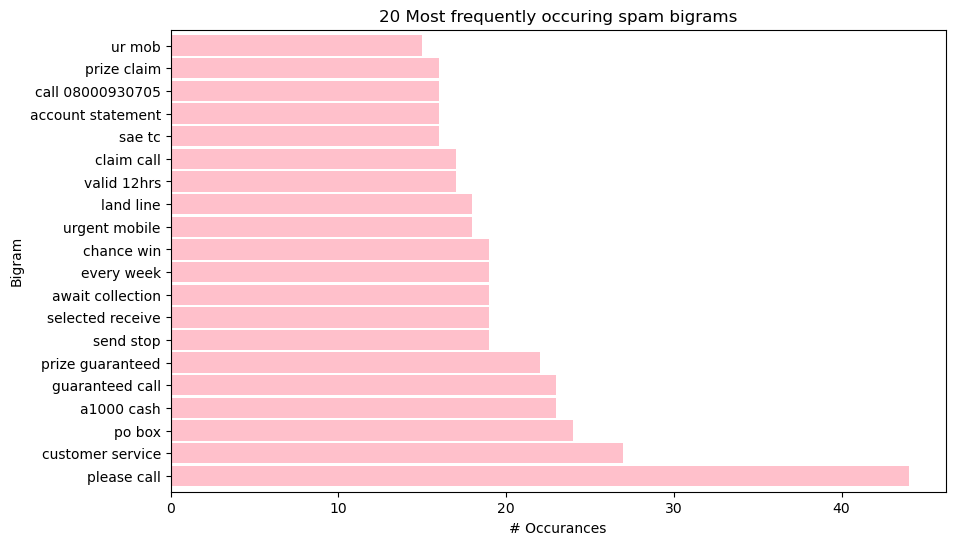

In [24]:
top_20_spam_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


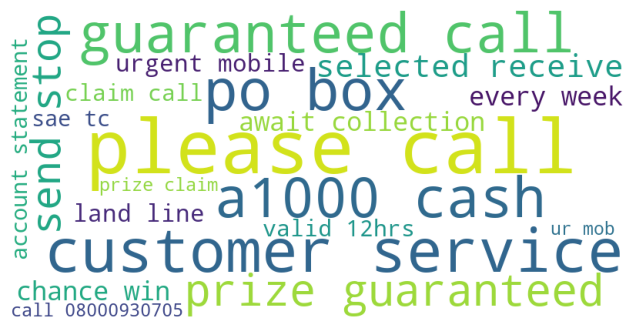

In [25]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


* Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.


In [26]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()


(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
Name: count, dtype: int64

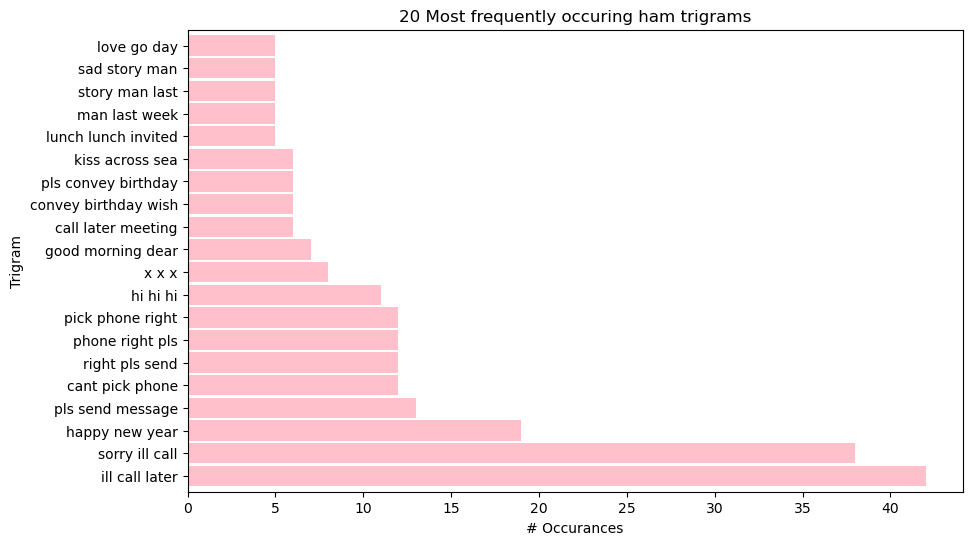

In [28]:
top_20_ham_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)


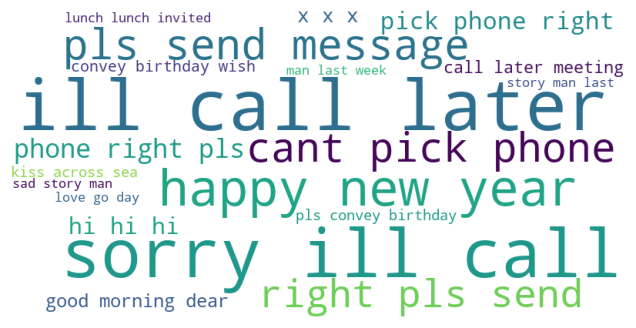

In [29]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


In [30]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
Name: count, dtype: int64

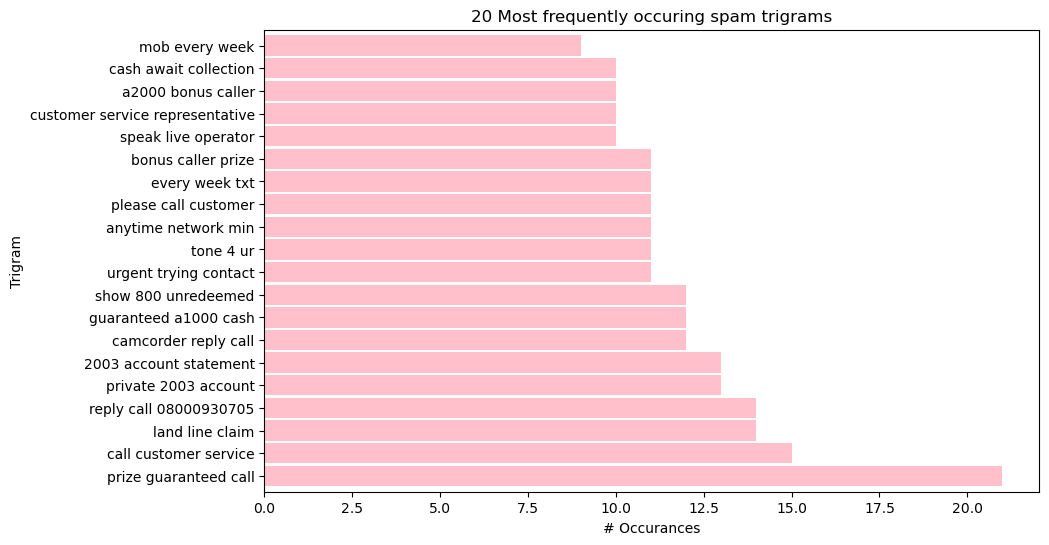

In [31]:
top_20_spam_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

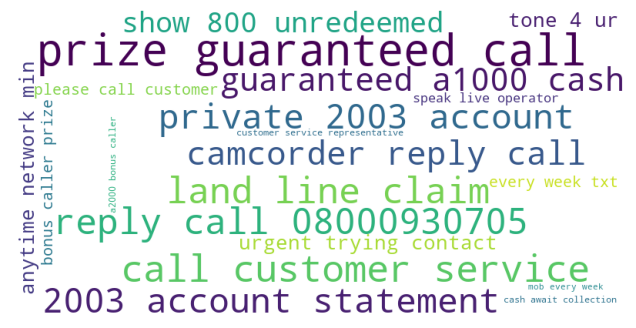

In [32]:



data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.


### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.